# Capstone Project - The Battle of the Neighborhoods

### Applied Data Science Capstone for the IBM Data Science Professional Certificate (Coursera) - June 2021

## Table of Contents

[Introduction and Business Problem](#Intro)  
[Data Presentation](#Data)  
[Methodology](#Methodology)  
[Results](#Results)    
[Discussion](#Discussion)  
[Conclusion](#Conclusion)

<a id='Intro'></a>
## Introduction and Business Problem

In this project, we are helping a friend who lives in **Montreal** to move to another neighborhood within the city. He asked us to suggest to him a neighborhood which is relatively similar to the one he lives in now in terms of **population density and the proximity of restaurants, shops and venues**. He has been living for several years in *Côte des Neiges - Notre Dame de Grâce*, a neighborhood located in the center of Montreal's island, but needs a change. The data science tools we learned will help us narrow down the optimal neighborhoods for him, by using two different clustering models.

<a id='Data'></a>
## Data Presentation

Two sets of data will be needed to solve the problem:  

1. Demographic information about the population of Montreal by neighborhood
2. Proximity and density of venues in each neighborhood

The list of Montreal's neighborhoods is found [here](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Montreal). The required data will be scraped from the site using the **Beautiful Soup package**. The demographic information is found from the last [Montreal Census data (from 2016)](http://ville.montreal.qc.ca/portal/page?_pageid=6897,68149701&_dad=portal&_schema=PORTAL). The data is already available as a .CSV file and provides the population density by neighborhood. The postal codes of each neighborhood is found [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H). Finally, the proximity and density of venues by neighborhood is found using the **Foursquare API**. Coordinates of each neighborhood are determined using the **Geocoder API**. 

<a id='Methodology'></a>
## Methodology

We will first start by importing the required data, analyzing it and cleaning it if needed. We import data about the different neighborhoods in Montreal and their postal codes and coordinates, the population density of each neighborhood and the number of venues around each neighborhood's center. We then use two different clustering models (KMeans and Hierarchical) to cluster the neighborhoods and select the ones that are similar to Côte des Neiges. 

In [1]:
#Import required libraries

#Pandas and Numpy
import numpy as np
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')

#Folium map
import folium 

#Web Scraping
import requests
from bs4 import BeautifulSoup

#Geocoding
from geopy.geocoders import Nominatim
import geocoder

#For Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix 
from scipy.cluster import hierarchy 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
import pylab

### Import Neighborhood Data

In [2]:
#Create a BeutifulSoup object to scrape the website with the Montreal Neighborhoods list
page = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Montreal')
soup = BeautifulSoup(page.text, 'html.parser')

In [3]:
#Retrieve Neighborhoods names (only main neighborhoods, not sub-Neighborhoods)
name = []
number = []
# For each item in all the li items
for item in soup.find_all('li'): 
    # find each span with class=toctext
    for post in item.find_all('span',{'class':'toctext'}): 
        # add the stripped string of each to name, one by one
        name.append(post.string.strip())
    # find each span with class=tocnumber
    for num in item.find_all('span',{'class':'tocnumber'}): 
        # add the number to number, one by one
        number.append(num.text.strip())

#Create dataframe with retrieved data and preview dataframe
data = {'Neighborhood Name':name,'Number':number}
df = pd.DataFrame(data)
print(df.shape)
df.head(7)

(61, 2)


,Neighborhood Name,Number
0,Ahuntsic-Cartierville,1
1,Anjou,2
2,Côte-des-Neiges–Notre-Dame-de-Grâce,3
3,Lachine,4
4,LaSalle,5
5,Le Plateau-Mont-Royal,6
6,The Plateau,6.1


In [4]:
#Clean dataframe
#Remove neighborhoods that are subsections of others (ex: 6.1)
def calclen(value):
    return len(value)
df['Len'] = df['Number'].apply(calclen)
df = df.drop(df[df.Len > 2].index)
#Discard neighborhoods that are after the 19th (there are only 19 official neighborhoods in Montreal)
df['Number'] = df['Number'].astype(str).astype(int)
df = df.drop(df[df.Number > 19].index)
#Remove unecessary columns
df = df.drop(['Number', 'Len'], axis=1)
#Clean neighborhood names
df['Neighborhood Name'] = df['Neighborhood Name'].str.replace('-',' ')
df['Neighborhood Name'] = df['Neighborhood Name'].str.replace('–',' ')
#Reset index column
df = df.reset_index(drop=True)
print(df.shape)
df.head(df.shape[0])

(19, 1)


,Neighborhood Name
0,Ahuntsic Cartierville
1,Anjou
2,Côte des Neiges Notre Dame de Grâce
3,Lachine
4,LaSalle
5,Le Plateau Mont Royal
6,Le Sud Ouest
7,L'Île Bizard Sainte Geneviève
8,Mercier Hochelaga Maisonneuve
9,Montréal Nord


### Import Population Density Data (2016)

In [5]:
#Import data from available CSV file 
popdata = pd.read_csv('Annuaire_Statistique_de_lagglomeration_de_montreal_2016.csv', encoding = 'unicode escape')
popdata.head()

,Quartier,Population_en_2016,Population_en_2011,Variation_2011_2016_(%),Superficie_(km2),Densité
0,AGGLOMÉRATION DE MONTRÉAL,"1,942,044","1,886,481",2.9,499.1,"3,891.20"
1,Ville de Montréal,"1,704,694","1,649,519",3.3,365.2,"4,668.30"
2,Ahuntsic-Cartierville,"134,245","126,891",5.8,24.2,"5,556.50"
3,Anjou,"42,796","41,928",2.1,13.7,"3,128.40"
4,Côte-des-Neiges-Notre-Dame-de-Grâce,"166,520","165,031",0.9,21.4,"7,766.80"


In [6]:
#Clean data
#Drop unwanted columns
popdata = popdata.drop(['Population_en_2011', 'Variation_2011_2016_(%)'], axis=1)
#Clean column names and convert column types from objects to numbers when needed
popdata['Population_en_2016'] = popdata['Population_en_2016'].str.replace(',','')
popdata['Densité'] = popdata['Densité'].str.replace(',','')
popdata['Densité'] = popdata['Densité'].astype(str).astype(float)
popdata['Population_en_2016'] = popdata['Population_en_2016'].astype(str).astype(float)
#Rename columns and clean neighborhood names from data file
popdata = popdata.rename(columns={"Quartier": "Neighborhood Name", "Population_en_2016": "Population (2016)", "Superficie_(km2)": "Area (km2)", "Densité": "Population Density"})
popdata['Neighborhood Name'] = popdata['Neighborhood Name'].str.replace('-',' ')

In [7]:
#Merge population data to neighborhood data using an outer join
data = pd.merge(df, popdata, on='Neighborhood Name', how='outer')
data = data.drop(data[data.index > 18].index)
data.head(data.shape[0])

,Neighborhood Name,Population (2016),Area (km2),Population Density
0,Ahuntsic Cartierville,134245.0,24.2,5556.5
1,Anjou,42796.0,13.7,3128.4
2,Côte des Neiges Notre Dame de Grâce,166520.0,21.4,7766.8
3,Lachine,44489.0,17.7,2510.7
4,LaSalle,76853.0,16.3,4723.6
5,Le Plateau Mont Royal,104000.0,8.1,12792.1
6,Le Sud Ouest,78151.0,15.7,4984.1
7,L'Île Bizard Sainte Geneviève,18413.0,23.6,780.2
8,Mercier Hochelaga Maisonneuve,136024.0,25.4,5353.2
9,Montréal Nord,84234.0,11.1,7623.0


### Get Postal Codes of Montreal's Neighborhoods

In [8]:
#Import Montreal's neighborhoods Postal Codes from a CSV file
codes = pd.read_csv('List_postalcodes_montreal_central.csv', encoding = 'unicode escape')
codes.head()

,ID,NEIGHBOURHOOD / LOCALITY,POSTAL CODES
0,1,Ahuntsic Cartierville,H2C
1,2,Anjou,H1J
2,3,Côte des Neiges Notre Dame de Grâce,H3V
3,4,Lachine,H8S
4,5,LaSalle,H8P


In [9]:
#Clean data
#Remove unwanted columns and rename Neighborhoods column
codes = codes.drop(['ID'], axis=1)
codes = codes.rename(columns={"NEIGHBOURHOOD / LOCALITY": "Neighborhood Name", "POSTAL CODES": "Postal Codes"})

### Get Coordinates of Neighborhoods

In [10]:
#Use the Geocoder API to retrieve coordinates
#Define function that returns latitude and longitude from a postal code and a neighborhood
def get_coordinates(postalcode, neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(postalcode, neighborhood))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude, longitude

In [11]:
#Obtain latitude and longitude coordinates for each neighborhood
for row in range(0,len(codes),1):
    postalcode = codes.loc[row, 'Postal Codes'] 
    neighborhood = codes.loc[row, 'Neighborhood Name'] 
    lat, lon = get_coordinates(postalcode, neighborhood)
    codes.loc[codes.index[row], 'Latitude'] = lat
    codes.loc[codes.index[row], 'Longitude'] = lon
print(codes.shape)
codes.head(codes.shape[0])

(19, 4)


,Neighborhood Name,Postal Codes,Latitude,Longitude
0,Ahuntsic Cartierville,H2C,45.56094,-73.65921
1,Anjou,H1J,45.61588,-73.57606
2,Côte des Neiges Notre Dame de Grâce,H3V,45.49737,-73.61008
3,Lachine,H8S,45.45041,-73.68545
4,LaSalle,H8P,45.42628,-73.60552
5,Le Plateau Mont Royal,H2J,45.52957,-73.58281
6,Le Sud Ouest,H3H,45.47426,-73.58158
7,L'Île Bizard Sainte Geneviève,H9C,45.49734,-73.89177
8,Mercier Hochelaga Maisonneuve,H1W,45.54239,-73.54722
9,Montréal Nord,H1H,45.59120,-73.63897


In [12]:
#Merge neighborhood names, population density and coordinates into a single dataframe 
#using an outer join
alldata = pd.merge(codes, data, on='Neighborhood Name', how='outer')
alldata.head(alldata.shape[0])

,Neighborhood Name,Postal Codes,Latitude,Longitude,Population (2016),Area (km2),Population Density
0,Ahuntsic Cartierville,H2C,45.56094,-73.65921,134245.0,24.2,5556.5
1,Anjou,H1J,45.61588,-73.57606,42796.0,13.7,3128.4
2,Côte des Neiges Notre Dame de Grâce,H3V,45.49737,-73.61008,166520.0,21.4,7766.8
3,Lachine,H8S,45.45041,-73.68545,44489.0,17.7,2510.7
4,LaSalle,H8P,45.42628,-73.60552,76853.0,16.3,4723.6
5,Le Plateau Mont Royal,H2J,45.52957,-73.58281,104000.0,8.1,12792.1
6,Le Sud Ouest,H3H,45.47426,-73.58158,78151.0,15.7,4984.1
7,L'Île Bizard Sainte Geneviève,H9C,45.49734,-73.89177,18413.0,23.6,780.2
8,Mercier Hochelaga Maisonneuve,H1W,45.54239,-73.54722,136024.0,25.4,5353.2
9,Montréal Nord,H1H,45.59120,-73.63897,84234.0,11.1,7623.0


### Create Map of Montreal's Neighborhoods

In [13]:
#Create map of Montreal's neighborhoods using the coordinates retrieved 
#Get Montreal coordinates first
address = 'Montreal'
geolocator = Nominatim(user_agent="montreal_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Montreal are {0}, {1}.'.format(latitude, longitude))

The geograpical coordinate of Montreal are 45.4972159, -73.6103642.


In [14]:
#Use Folium library to create Montreal map
#Create map of Montreal using latitude and longitude values
map_montreal = folium.Map(location=[latitude, longitude], zoom_start=10)

#Add markers to map
for lat, lng, neighborhood in zip(codes['Latitude'], codes['Longitude'], codes['Neighborhood Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
#Show map
map_montreal

### Foursquare API

In [15]:
#Define Foursquare API credentials to use API 
CLIENT_ID = 'E1Z5QXX4BBPBGKCXXQTDQCCXYD0PJ2TFESVQ0JOOJBE44QLU' # your Foursquare ID
CLIENT_SECRET = '1KCR30LSZA0XWAXG2QHRJVRRJHJDJCEGD3LROOXXF325FG1T' # your Foursquare Secret
ACCESS_TOKEN = '1HHYEKOXCKXRS4NZHQSGTAZLIUL20JNRNPNFCOMFSXLYXTEF' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: E1Z5QXX4BBPBGKCXXQTDQCCXYD0PJ2TFESVQ0JOOJBE44QLU
CLIENT_SECRET:1KCR30LSZA0XWAXG2QHRJVRRJHJDJCEGD3LROOXXF325FG1T


In [16]:
#Obtain radius of each Neighborhood based on their areas to specify search radius for Foursquare API
#Keep only a certain percentage of the radii obtained, so that neighborhood limits don't cross each others
radius_coeff = 0.42
def calcradius(value):
    radius = np.sqrt(value/np.pi)
    return (radius*1000*radius_coeff)
alldata['Radius(m)'] = alldata['Area (km2)'].apply(calcradius)
alldata

,Neighborhood Name,Postal Codes,Latitude,Longitude,Population (2016),Area (km2),Population Density,Radius(m)
0,Ahuntsic Cartierville,H2C,45.56094,-73.65921,134245.0,24.2,5556.5,1165.687225
1,Anjou,H1J,45.61588,-73.57606,42796.0,13.7,3128.4,877.070770
2,Côte des Neiges Notre Dame de Grâce,H3V,45.49737,-73.61008,166520.0,21.4,7766.8,1096.178402
3,Lachine,H8S,45.45041,-73.68545,44489.0,17.7,2510.7,996.921557
4,LaSalle,H8P,45.42628,-73.60552,76853.0,16.3,4723.6,956.683219
5,Le Plateau Mont Royal,H2J,45.52957,-73.58281,104000.0,8.1,12792.1,674.398916
6,Le Sud Ouest,H3H,45.47426,-73.58158,78151.0,15.7,4984.1,938.910466
7,L'Île Bizard Sainte Geneviève,H9C,45.49734,-73.89177,18413.0,23.6,780.2,1151.145859
8,Mercier Hochelaga Maisonneuve,H1W,45.54239,-73.54722,136024.0,25.4,5353.2,1194.238897
9,Montréal Nord,H1H,45.59120,-73.63897,84234.0,11.1,7623.0,789.470385


In [17]:
#Define function that returns nerby venues for each Neighborhood center
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
            
        #Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        #Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
#Get all nearby venues for each neighborhood
montreal_venues = getNearbyVenues(names=alldata['Neighborhood Name'], latitudes=alldata['Latitude'], longitudes=alldata['Longitude'], radius=alldata['Radius(m)'])
print(montreal_venues.shape)
montreal_venues.head()

(675, 7)


,Neighborhood Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ahuntsic Cartierville,45.56094,-73.65921,L'Estaminet,45.560277,-73.657848,Restaurant
1,Ahuntsic Cartierville,45.56094,-73.65921,Café Le Petit Flore,45.558576,-73.658798,Café
2,Ahuntsic Cartierville,45.56094,-73.65921,Gourmet Privilège,45.557743,-73.659355,Dessert Shop
3,Ahuntsic Cartierville,45.56094,-73.65921,La Fromagerie Hamel,45.557576,-73.659493,Cheese Shop
4,Ahuntsic Cartierville,45.56094,-73.65921,Café Aroma Paninoteca,45.562833,-73.656398,Café


In [19]:
#Make sure that venues are not listed more than once (meaning that they would appear in two different
#neighborhoods)
#If they are listed twice (meaning that the function below returns False), reduce the radius of each
#neighborhood calculated from their respective areas, so that neighborhood limits don't cross each other
#From this iterative process, the optimal (largest radius coefficient that does not return 
#duplicate venues is 0.42)
print(montreal_venues["Venue Latitude"].is_unique and montreal_venues["Venue Longitude"].is_unique)

True


In [20]:
#Retrieve the number of venues in each neighborhood and put data into a dataframe
num_venues = montreal_venues.groupby('Neighborhood Name').count()['Venue']
num_venues = num_venues.to_frame()
num_venues = num_venues.rename(columns={"Venue": "Number of Venues"})
num_venues.head()

,Number of Venues
Neighborhood Name,
Ahuntsic Cartierville,59
Anjou,7
Côte des Neiges Notre Dame de Grâce,42
L'Île Bizard Sainte Geneviève,5
LaSalle,17


In [21]:
#Merge neighborhood names, population density. coordinates and number of venues into 
#a single dataframe using an outer join
alldata = pd.merge(alldata, num_venues, on='Neighborhood Name', how='outer')
alldata.head(alldata.shape[0])

,Neighborhood Name,Postal Codes,Latitude,Longitude,Population (2016),Area (km2),Population Density,Radius(m),Number of Venues
0,Ahuntsic Cartierville,H2C,45.56094,-73.65921,134245.0,24.2,5556.5,1165.687225,59
1,Anjou,H1J,45.61588,-73.57606,42796.0,13.7,3128.4,877.070770,7
2,Côte des Neiges Notre Dame de Grâce,H3V,45.49737,-73.61008,166520.0,21.4,7766.8,1096.178402,42
3,Lachine,H8S,45.45041,-73.68545,44489.0,17.7,2510.7,996.921557,4
4,LaSalle,H8P,45.42628,-73.60552,76853.0,16.3,4723.6,956.683219,17
5,Le Plateau Mont Royal,H2J,45.52957,-73.58281,104000.0,8.1,12792.1,674.398916,100
6,Le Sud Ouest,H3H,45.47426,-73.58158,78151.0,15.7,4984.1,938.910466,94
7,L'Île Bizard Sainte Geneviève,H9C,45.49734,-73.89177,18413.0,23.6,780.2,1151.145859,5
8,Mercier Hochelaga Maisonneuve,H1W,45.54239,-73.54722,136024.0,25.4,5353.2,1194.238897,70
9,Montréal Nord,H1H,45.59120,-73.63897,84234.0,11.1,7623.0,789.470385,18


### Clustering Neighborhoods

Two different models are used for clustering neighborhood: KMeans and Hierarchical models. The results will be analyzed and compared for each model, for more accuracy in our analysis.

In [22]:
#Define number of clusters used for the Kmeans model and the Hierarchical model
#The number of clusters will be varied to see the variation in the results obtained
clusterNum = 5

#### K-Means Clustering

In [23]:
#Define data used for KMeans analysis
kmeans_data = alldata
kmeans_data = kmeans_data.drop(['Postal Codes', 'Latitude', 'Longitude', 'Area (km2)', 'Population (2016)'], axis=1)
kmeans_data.head()

,Neighborhood Name,Population Density,Radius(m),Number of Venues
0,Ahuntsic Cartierville,5556.5,1165.687225,59
1,Anjou,3128.4,877.070770,7
2,Côte des Neiges Notre Dame de Grâce,7766.8,1096.178402,42
3,Lachine,2510.7,996.921557,4
4,LaSalle,4723.6,956.683219,17


In [24]:
#Scale data
x = kmeans_data.values[:,1:]
StandardScaler().fit_transform(x);

In [25]:
#Fit model
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(x)
labels = k_means.labels_
print(labels)

[2 0 1 0 2 3 2 4 2 1 2 0 0 1 0 2 1 2 1]


In [26]:
#Add labels to data for each neighborhood
kmeans_data["Label"] = labels
kmeans_data.head(5)

,Neighborhood Name,Population Density,Radius(m),Number of Venues,Label
0,Ahuntsic Cartierville,5556.5,1165.687225,59,2
1,Anjou,3128.4,877.070770,7,0
2,Côte des Neiges Notre Dame de Grâce,7766.8,1096.178402,42,1
3,Lachine,2510.7,996.921557,4,0
4,LaSalle,4723.6,956.683219,17,2


In [27]:
#Get mean population density and number of venues for each cluster
kmeans_data.groupby('Label').mean()

,Population Density,Radius(m),Number of Venues
Label,,,
0,2607.080000,1239.785547,11.400000
1,8009.280000,906.212351,30.600000
2,5434.514286,936.665339,51.428571
3,12792.100000,674.398916,100.000000
4,780.200000,1151.145859,5.000000


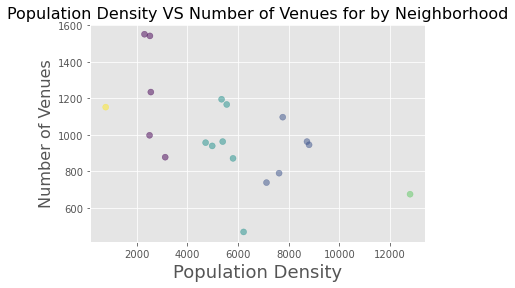

In [28]:
#Plot Population Density VS Number of Venues for by Neighborhood and their respective cluster
plt.scatter(x[:, 0], x[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population Density', fontsize=18)
plt.ylabel('Number of Venues', fontsize=16)
plt.title('Population Density VS Number of Venues for by Neighborhood', fontsize=16)
plt.show()

In [29]:
#Add column to indicate if neighborhood is in the same cluster as Côte des Neiges
cond = []
for idx in range(0, len(kmeans_data), 1):
    diff = kmeans_data.iloc[idx]['Label'] == kmeans_data.iloc[2]['Label']
    #print(diff)
    if diff:
        cond.append('1')
    else:
        cond.append('0')
kmeans_data['Similar on Kmeans?'] = pd.DataFrame(cond)
kmeans_data.head()

,Neighborhood Name,Population Density,Radius(m),Number of Venues,Label,Similar on Kmeans?
0,Ahuntsic Cartierville,5556.5,1165.687225,59,2,0
1,Anjou,3128.4,877.070770,7,0,0
2,Côte des Neiges Notre Dame de Grâce,7766.8,1096.178402,42,1,1
3,Lachine,2510.7,996.921557,4,0,0
4,LaSalle,4723.6,956.683219,17,2,0


#### Hierarchical Clustering

In [30]:
#Define data for Hierarchical analysis
hier_data = alldata
hier_data = hier_data.drop(['Postal Codes', 'Latitude', 'Longitude', 'Radius(m)', 'Area (km2)', 'Population (2016)'], axis=1)
hier_data

,Neighborhood Name,Population Density,Number of Venues
0,Ahuntsic Cartierville,5556.5,59
1,Anjou,3128.4,7
2,Côte des Neiges Notre Dame de Grâce,7766.8,42
3,Lachine,2510.7,4
4,LaSalle,4723.6,17
5,Le Plateau Mont Royal,12792.1,100
6,Le Sud Ouest,4984.1,94
7,L'Île Bizard Sainte Geneviève,780.2,5
8,Mercier Hochelaga Maisonneuve,5353.2,70
9,Montréal Nord,7623.0,18


In [31]:
#Scale data
X = hier_data[['Population Density', 'Number of Venues']].values
min_max_scaler = MinMaxScaler()
X_mtx = min_max_scaler.fit_transform(X)
X_mtx [0:5]

array([[0.39763068, 0.57291667],
       [0.19548947, 0.03125   ],
       [0.58163987, 0.39583333],
       [0.14406547, 0.        ],
       [0.32829111, 0.13541667]])

In [32]:
#Compute distance matrix of scaled data
dist_matrix = euclidean_distances(X_mtx,X_mtx) 
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')

<ipython-input-32-35d87a86b36f>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')


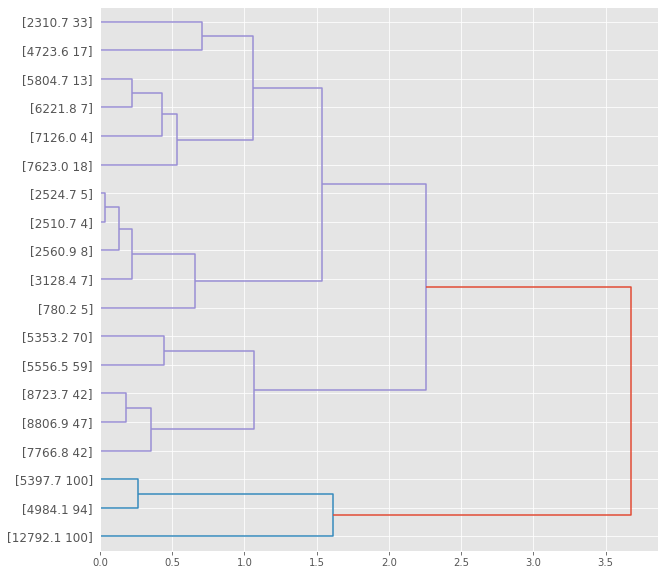

In [33]:
#Plot hierarchical tree for better understanding of clustering model
fig = pylab.figure(figsize=(10,10))
def llf(id):
    return '[%s %s]' % (hier_data['Population Density'][id], hier_data['Number of Venues'][id])
dendro = hierarchy.dendrogram(Z_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [34]:
#Agglomerate neighborhoods using agglomerative clustering
agglom = AgglomerativeClustering(n_clusters = clusterNum, linkage = 'complete')
agglom.fit(dist_matrix)
agglom.labels_

C:\Users\bales\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:492: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([0, 1, 0, 1, 2, 3, 4, 1, 0, 2, 2, 1, 1, 0, 2, 2, 2, 4, 0],
      dtype=int64)

In [35]:
#Add labels to data for each neighborhood
hier_data['Cluster'] = agglom.labels_
hier_data.head()

,Neighborhood Name,Population Density,Number of Venues,Cluster
0,Ahuntsic Cartierville,5556.5,59,0
1,Anjou,3128.4,7,1
2,Côte des Neiges Notre Dame de Grâce,7766.8,42,0
3,Lachine,2510.7,4,1
4,LaSalle,4723.6,17,2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'Number of Venues')

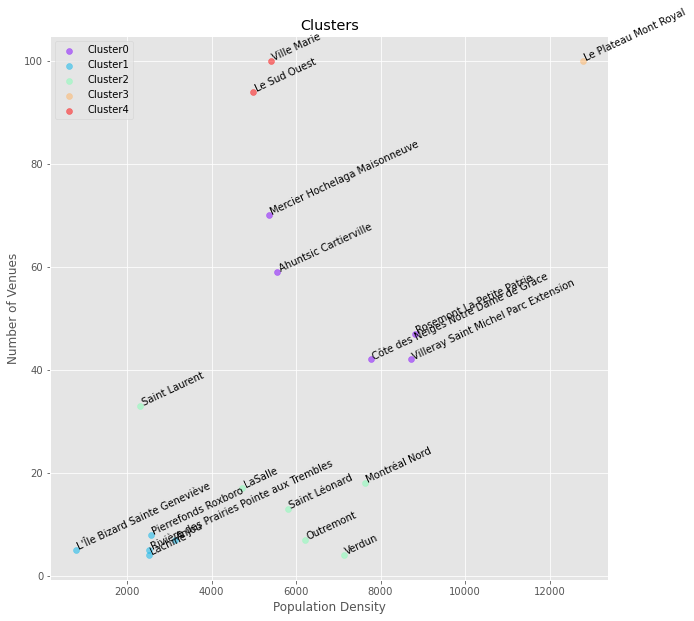

In [36]:
#Plot Population Density VS Number of venues for each neighborhood and their respective cluster
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

plt.figure(figsize=(10,10));

for color, label in zip(colors, cluster_labels):
    subset = hier_data[hier_data.Cluster == label]
    for i in subset.index:
            plt.text(subset['Population Density'][i], subset['Number of Venues'][i], subset['Neighborhood Name'][i], rotation=25) 
    plt.scatter(subset['Population Density'], subset['Number of Venues'], c=color, label='Cluster'+str(label),alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('Population Density')
plt.ylabel('Number of Venues')

In [37]:
#Obtain population density and number of venues mean for each cluster
hier_data2 = hier_data.groupby(['Cluster'])['Population Density','Number of Venues'].mean()
hier_data2

<ipython-input-37-6ec1dece18b3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hier_data2 = hier_data.groupby(['Cluster'])['Population Density','Number of Venues'].mean()


,Population Density,Number of Venues
Cluster,,
0,7241.420000,52.000000
1,2300.980000,5.800000
2,5634.966667,15.333333
3,12792.100000,100.000000
4,5190.900000,97.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'Number of Venues')

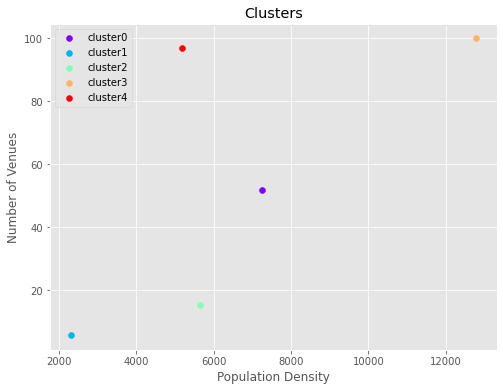

In [38]:
#Plot cluster means
plt.figure(figsize=(8,6))
for color, label in zip(colors, cluster_labels):
    subset = hier_data2.loc[(label,),]
    plt.scatter(subset['Population Density'], subset['Number of Venues'], c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('Population Density')
plt.ylabel('Number of Venues')

In [39]:
#Add column to indicate if neighborhood is in the same cluster as Côte des Neiges
cond1 = []
for idx in range(0, len(hier_data), 1):
    diff = hier_data.iloc[idx]['Cluster'] == hier_data.iloc[2]['Cluster']
    if diff:
        cond1.append('1')
    else:
        cond1.append('0')
hier_data['Similar on Hierarchical?'] = pd.DataFrame(cond1)
hier_data.head()

,Neighborhood Name,Population Density,Number of Venues,Cluster,Similar on Hierarchical?
0,Ahuntsic Cartierville,5556.5,59,0,1
1,Anjou,3128.4,7,1,0
2,Côte des Neiges Notre Dame de Grâce,7766.8,42,0,1
3,Lachine,2510.7,4,1,0
4,LaSalle,4723.6,17,2,0


<a id='Results'></a>

<a id='Results'></a>
## Results

### Merge Results

In [40]:
#Merge data from KMeans model and from Hierarchical model
results = pd.merge(kmeans_data, hier_data, on='Neighborhood Name', how='outer')
final_results = results[['Similar on Kmeans?', 'Similar on Hierarchical?']].astype(int)
final_results['Neighborhood Name'] = results['Neighborhood Name']
final_results = final_results.drop(final_results[final_results.index == 2].index)
final_results = final_results.set_index('Neighborhood Name')
final_results.head(final_results.shape[0])

,Similar on Kmeans?,Similar on Hierarchical?
Neighborhood Name,,
Ahuntsic Cartierville,0,1
Anjou,0,0
Lachine,0,0
LaSalle,0,0
Le Plateau Mont Royal,0,0
Le Sud Ouest,0,0
L'Île Bizard Sainte Geneviève,0,0
Mercier Hochelaga Maisonneuve,0,1
Montréal Nord,1,0


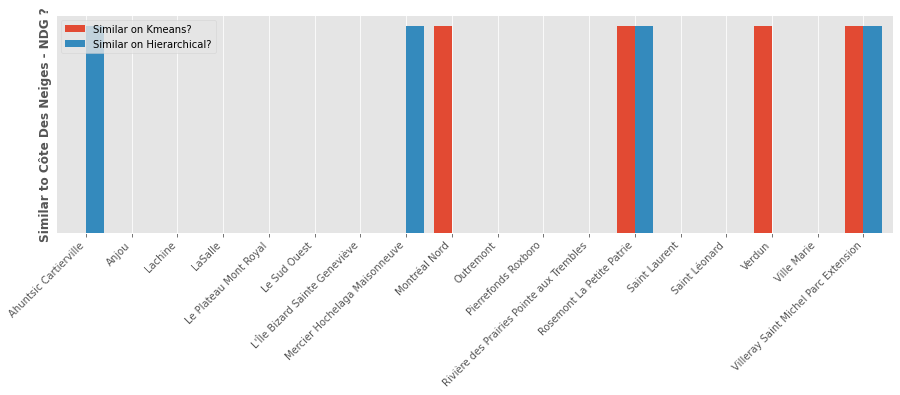

In [41]:
#Plot bar graph for each neighborhood to indicate if it is considered similar to Côte des Neiges based
#on KMeans model or Hierarchical model
final_results.plot(kind='bar', width = 0.80, figsize=(15, 4)) 
plt.ylabel('Similar to Côte Des Neiges - NDG ?', fontweight = 'bold')
plt.xlabel('')
plt.yticks([])
plt.xticks(rotation=45, fontsize='10', horizontalalignment='right')
plt.show()

<a id='Discussion'></a>
## Discussion

Similar neighborhoods to Cote des Neiges are visible in the graph above, shown in the Results section. The best neighborhoods are chosen to be the ones that are indicated similar both by the KMeans model and the Hierarchical model. Several numbers of clusters are used, to see the variation in the results.

1. For 2 clusters, similar neighborhoods are: Montréal-Nord, Rosemont, Verdun and Villeray/St-Michel
2. For 3, 4 and 5 clusters, similar neighborhoods are: Rosemont and Villeray/St-Michel
3. For 6 or more clusters, no neighborhoods are similar on both KMeans and Hierarchical

It can be seen that, as expected, more neighborhoods are considered similar to the one we're comparing them to when less clusters are used. Increasing the number of clusters to 8 gives us only one final neighborhood. It can be concluded that **Rosemont and Villeray/St-Michel** are the optimal neighborhoods, since they are the most similar to Côte des Neiges, when the number of clusters is increased. They are therefore the best neighborhoods for our friend to choose from, since they are similar in terms of population density and in terms of numbers of venues, which were the two criteria he specified. 

<a id='Conclusion'></a>
## Conclusion

In conclusion, data science tools and methodology were used to solve a simple clustering problem, where similar neighborhoods were clustered to suggest to our friend the best neighborhood in Montreal in which to move, based on population density and venues density. Data analysis, preparation and cleaning was done in order for the required data to be easily processed by the machine learning algorithms. Two clustering models were then used to segment and cluster the neighborhoods based on two independent variables. The final results were obtained by taking the common results from the two models. 

Our friend now has to make a choice betwen **Rosemont and Villeray/St-Michel**, the two optimal neighborhoods we suggested him, and we can go on helping other friends with their problems by using the machine learning and data science tools we learned in this course!